In [1]:
import io
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from collections import Counter
import pickle as pkl
import random
import pdb
random.seed(134)

In [2]:
torch.cuda.current_device()

0

In [3]:
torch.cuda.is_available()

True

In [4]:
torch.cuda.get_device_name(0)

'Tesla V100-SXM2-16GB'

In [5]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')
# dtype = torch.FloatTensor
dtype_float = torch.cuda.FloatTensor # Uncomment this to run on GPU
dtype_long = torch.cuda.LongTensor

In [6]:
# Summary: you can call line.split() to immediately get the tokenized version of 
# the sentences. Normally you would have to run the text through a proper tokenizer.
"""
You should create a subclass for Dataset, but not for Dataloader. 
You should probably also define a custom collate_fn, 
but you should also only need to do this once.
You will instantiate separate Datasets: e.g. train_dataset and val_dataset. 
Then you should create a Dataloader around each one: train_dataloader and val_dataloader.
For your max length, that should be determined based on your training set 
(you should pretend you do not have access to your validation set when choosing 
such "hyperparameters", to avoid biasing your results.

sent1_vector = rnn(sent1)
sent2_vector = rnn(sent2)
combined_vector = torch.cat([sent1_vector, sent2_vector], dim=1)

nn.Sequential(nn.Linear(x, hidden_size), 
              nn.ReLU(inplace=True), 
              nn.Linear(hidden_size, num_classes))

You are required to concatenate the representations, not the sentences. 
The idea is that you will encode each of your sentences through an 
encoder (CNN or RNN) and extract a fixed-length vector representation 
of the sentences. You will then concatenate the two representations and 
feed that through a fully-connected layer.

Transfer the string into word vectors using fast text, process 
them with data loader, feed them separately into the encoder, 
get the output representation, concat them and then fed that into a 
fully-connected layer for classification.
"""
""

''

In [7]:
class ModelDatasetBuilder(object):
    """
    Use this class to build the datasets for model consumption
    """
    def __init__(self, data_dir, vocab_size=10000):
        self.PAD_IDX = 0
        self.UNK_IDX = 1
        self.TKN_OFFSET = 2
        self.EMB_SIZE = 300
        self.vocab_size = vocab_size
        self.id2token = []
        self.token2id = None
        self.fasttext_emb_map = {}
        pass
    
    def load_fasttext_vectors_into_vocabulary(self, fname):
        self.id2token = [None] * (self.vocab_size + self.TKN_OFFSET)
        with open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore') as fin:
            n, d = map(int, fin.readline().split())
            for i, line in enumerate(fin):
                tokens = line.rstrip().split(' ')
                self.id2token[i + self.TKN_OFFSET] = tokens[0]
                self.fasttext_emb_map[tokens[0]] = list(map(float, tokens[1:]))
                if i>self.vocab_size - self.TKN_OFFSET:
                    break
        self.fasttext_emb_map['<unk>'] = np.random.rand(1,self.EMB_SIZE).tolist()[0]
        self.fasttext_emb_map['<pad>'] = np.zeros( (1,self.EMB_SIZE) ).tolist()[0]
        self.id2token[self.PAD_IDX] = '<pad>'
        self.id2token[self.UNK_IDX] = '<unk>'
        self.token2id = dict(zip(self.id2token, range(0,len(self.id2token)))) 
        self.token2id['<pad>'] = self.PAD_IDX 
        self.token2id['<unk>'] = self.UNK_IDX
        self.fasttext_emb_map['<unk>'] = np.random.rand(1,self.EMB_SIZE).tolist()[0]
        self.fasttext_emb_map['<pad>'] = np.zeros( (1,self.EMB_SIZE) ).tolist()[0]
    
    def get_indexed_data(self, data_path, max_data):
        label_mapper = {
            "contradiction\n": 0,
            "entailment\n": 1,
            "neutral\n": 2
        }
        lines = []
        with open(data_path, 'r', newline='\n') as f:
            next(f)
            i = 0
            for line in f:
                parts = line.split('\t')
                premise_tokens =  parts[0].split()
                premise_indices = [self.token2id[token] if token in self.token2id else self.UNK_IDX for token in premise_tokens]
                hypothesis_tokens =  parts[1].split()
                hypothesis_indices = [self.token2id[token] if token in self.token2id else self.UNK_IDX for token in hypothesis_tokens]
                label =  label_mapper[parts[2]]
                lines.append( (premise_indices, hypothesis_indices, label) )
                if i > max_data:
                    break
                i += 1
        print("All of the lines!!!")
        print(len(lines))
        return lines
    
    def get_embedding_vector(self):
        if not self.id2token:
            raise ValueError('Please run load_fasttext_vectors_into_vocabulary first!')
        pre_trained_embeddings = []
        for i in range(0, self.vocab_size):
            token = self.id2token[i]
            pre_trained_embeddings.append(self.fasttext_emb_map[token])
#         weight = torch.FloatTensor(pre_trained_embeddings)
        weight = torch.FloatTensor(pre_trained_embeddings).type(dtype_float).cuda()
#         weight = weight.long()
        embedding = nn.Embedding.from_pretrained(weight, freeze=True).cuda()
        return embedding
    
    def get_indexed_text_vectors(self, max_data=float("inf")):
        """
        Gets the torch.utils.data.Dataset preproccessed version
        """
        if not self.id2token:
            raise ValueError('Please run load_fasttext_vectors_into_vocabulary first!')
        training_vectors = self.get_indexed_data('hw2_data/snli_train.tsv', max_data)
        val_vectors = self.get_indexed_data('hw2_data/snli_val.tsv', max_data)
        return training_vectors, val_vectors



In [8]:
from operator import itemgetter
import numpy as np
import torch
from torch.utils.data import Dataset

MAX_SENTENCE_LENGTH = 100

class SnliDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, premises, hypotheses, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.premises = premises
        self.hypotheses = hypotheses
        self.target_list = target_list
        assert (len(self.premises) == len(self.target_list))
        assert (len(self.hypotheses) == len(self.target_list))

    def __len__(self):
        return len(self.premises)
        
    def __getitem__(self, index):
        """
        Triggered when you call dataset[i]
        """
        premise_idx = self.premises[index][:MAX_SENTENCE_LENGTH]
        hypothesis_idx = self.hypotheses[index][:MAX_SENTENCE_LENGTH]
        label = self.target_list[index]
        return [premise_idx, hypothesis_idx, len(premise_idx), len(hypothesis_idx), label]
    
def snli_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    premise_list = []
    hypothesis_list = []
    label_list = []
    premise_length_list = []
    hypothesis_length_list = []
    sorted_batch = sorted(batch, key=lambda x: len(x[0]), reverse=True)
    for datum in sorted_batch:
        label_list.append(datum[4])
        premise_length_list.append(MAX_SENTENCE_LENGTH)
        hypothesis_length_list.append(MAX_SENTENCE_LENGTH)
    # padding
    for datum in sorted_batch:
        padded_premise_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[2])), 
                                mode="constant", constant_values=0)
        premise_list.append(padded_premise_vec)
        padded_hypothesis_vec = np.pad(np.array(datum[1]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[3])), 
                                mode="constant", constant_values=0)
        hypothesis_list.append(padded_hypothesis_vec)

    collation = [torch.FloatTensor(premise_list).type(dtype_long), 
                 torch.FloatTensor(hypothesis_list).type(dtype_long), 
                 torch.FloatTensor(hypothesis_length_list).type(dtype_long), 
                 torch.FloatTensor(label_list).type(dtype_long)]
    return collation

In [9]:
#List of questions
"""
- Do I need to instantiate separate versions of the model for each premise and hypothesis
both linear and RNN
- Do I have to instantiate in the init function or can I do it in the forward for things
like the nn.Sequential operator
- How do I parallelize it?
- How does the conv net work?
"""
""

''

In [10]:
class GRU(nn.Module):
    def __init__(self, embeddings, hidden_size, num_layers, num_classes):
        # RNN Accepts the following hyperparams:
        # emb_size: Embedding Size
        # hidden_size: Hidden Size of layer in RNN
        # num_layers: number of layers in RNN
        # num_classes: number of output classes
        # vocab_size: vocabulary size        
        super(GRU, self).__init__()
        print("GRU Settings...")
        print("embeddings: " + str(embeddings.embedding_dim))
        print("hidden size: " + str(hidden_size))
        print("num layers: " + str(num_layers))
        print("num classes: " + str(num_classes))
        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.embedding = embeddings.cuda()
        self.rnn_premise = nn.GRU(embeddings.embedding_dim, 
                          hidden_size, 
                          num_layers, 
                          batch_first=True)
        self.rnn_hypothesis = nn.GRU(embeddings.embedding_dim, 
                          hidden_size, 
                          num_layers, 
                          batch_first=True)
        self.linear_premise = nn.Linear(hidden_size, num_classes)
        self.linear_hyp = nn.Linear(hidden_size, num_classes)
        
        self.linear_fully_connected = nn.Linear(6, 32)
        self.relu = nn.ReLU(inplace=True)
        self.linear_out = nn.Linear(32, num_classes)

    def init_hidden(self, batch_size):
        # Function initializes the activation of recurrent neural net at timestep 0
        # Needs to be in format (num_layers, batch_size, hidden_size)
        hidden = torch.randn(self.num_layers, batch_size, self.hidden_size)

        return hidden

    def forward(self, premises, hypotheses, lengths):
        # reset hidden state
        batch_size, seq_len = premises.size()
        self.hidden = self.init_hidden(batch_size)
        
        # Run encoder for the premise
        # get embedding of tokens
        embed_premises = self.embedding(premises)
        # pack padded sequence
        embed_premises = torch.nn.utils.rnn.pack_padded_sequence(embed_premises, 
                                                                 lengths, 
                                                                 batch_first=True)
        # fprop though RNN
        rnn_out_prem, self.hidden = self.rnn_premise(embed_premises, self.hidden)
        # undo packing
        rnn_out_prem, _ = torch.nn.utils.rnn.pad_packed_sequence(rnn_out_prem, 
                                                                 batch_first=True)
        # sum hidden activations of RNN across time
        rnn_out_prem = torch.sum(rnn_out_prem, dim=1)
        logits_prem = self.linear_premise(rnn_out_prem)

        # Run encoder for the hypothesis
        embed_hyp = self.embedding(hypotheses)
#         embed_hyp = torch.nn.utils.rnn.pack_padded_sequence(embed_hyp, 
#                                                                  lengths.numpy(), 
#                                                                  batch_first=True)
        rnn_out_hyp, self.hidden = self.rnn_hypothesis(embed_hyp, self.hidden)
#         rnn_out_hyp, _ = torch.nn.utils.rnn.pad_packed_sequence(rnn_out_hyp, 
#                                                                  batch_first=True)
        rnn_out_hyp = torch.sum(rnn_out_hyp, dim=1)
        logits_hyp = self.linear_hyp(rnn_out_hyp)
        
        # Interact the two sentences
        combined_sentences = torch.cat([logits_prem, logits_hyp], dim=1)
        out = self.linear_fully_connected(combined_sentences)
        out = self.relu(out)
        logits = self.linear_out(out)
        return logits


In [11]:
class CNN(nn.Module):
    def __init__(self, embeddings, hidden_size, num_layers, num_classes, kernel_size=3):

        super(CNN, self).__init__()
        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.embedding = embeddings.cuda()
    
        self.conv1 = nn.Conv1d(embeddings.embedding_dim, hidden_size, kernel_size, padding=1)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size, padding=1)
        
        self.max_pool = nn.MaxPool1d(kernel_size, stride=2)
        self.linear = nn.Linear(99, 128)
        #128 x 256
        self.linear_fully_connected = nn.Linear(256, 128)
        self.relu = nn.ReLU(inplace=True)
        self.linear_out = nn.Linear(128, num_classes)

    def forward(self, premises, hypotheses, lengths):
        premises, hypotheses, lengths = premises.cuda(), hypotheses.cuda(), lengths.cuda()
        
        batch_size, seq_len = premises.size()
        
        # Run encoder for the premises
#         print("DEGUB-----")
#         print(premises)
#         print(premises.double())
#         print(premises.int())
#         print(premises.type(torch.cuda.LongTensor))
        embed_premises = self.embedding(premises)
        hidden_prem = self.conv1(embed_premises.transpose(1,2)).transpose(1,2)
        hidden_prem = F.relu(
            hidden_prem.contiguous().view(-1, hidden_prem.size(-1))
                       ).view(batch_size, seq_len, hidden_prem.size(-1))

        hidden_prem = self.conv2(hidden_prem.transpose(1,2)).transpose(1,2)
        hidden_prem = F.relu(
            hidden_prem.contiguous().view(-1, hidden_prem.size(-1))
                       ).view(batch_size, seq_len, hidden_prem.size(-1))
        
        pooled_prem = self.max_pool(hidden_prem)

        hidden_prem = torch.sum(pooled_prem, dim=1)
        logits_prem = self.linear(hidden_prem)
        
        # Run encoder for the hypothesis
        embed_hyp = self.embedding(hypotheses)
        hidden_hyp = self.conv1(embed_hyp.transpose(1,2)).transpose(1,2)
        hidden_hyp = F.relu(
            hidden_hyp.contiguous().view(-1, hidden_hyp.size(-1))
                       ).view(batch_size, seq_len, hidden_hyp.size(-1))

        hidden_hyp = self.conv2(hidden_hyp.transpose(1,2)).transpose(1,2)
        hidden_hyp = F.relu(
            hidden_hyp.contiguous().view(-1, hidden_hyp.size(-1))
                       ).view(batch_size, seq_len, hidden_hyp.size(-1))
        
        pooled_hyp = self.max_pool(hidden_hyp)

        hidden_hyp = torch.sum(pooled_hyp, dim=1)
        logits_hyp = self.linear(hidden_hyp)
        
        # Interact the two sentences
        combined_sentences = torch.cat([logits_prem, logits_hyp], dim=1)
        out = self.linear_fully_connected(combined_sentences)
        out = self.relu(out)
        logits = self.linear_out(out)
        return logits

In [27]:
import time

def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for premises, hypotheses, lengths, labels in loader:
        premises_batch, hypotheses_batch, lengths_batch, label_batch = premises, hypotheses, lengths, labels
        outputs = F.softmax(model(premises_batch, hypotheses_batch, lengths_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]

        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

def run_model(mdb, model, accuracies, learning_rate, num_epochs, train_loader, val_loader):
    model.cuda()

    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    total_step = len(train_loader)
    start = time.time()
    for epoch in range(num_epochs):
        for i, (premises, hypotheses, lengths, labels) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            # Forward pass
            outputs = model(premises, hypotheses, lengths)
            loss = criterion(outputs, labels)
#             print(loss)

            # Backward and optimize
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and i % 100 == 0:
                # validate
                train_acc = test_model(train_loader, model)
                print('Epoch: [{}/{}], Step: [{}/{}], Training Acc: {}'.format(
                           epoch+1, num_epochs, i+1, len(train_loader), train_acc))
                val_acc = test_model(val_loader, model)
                print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(
                           epoch+1, num_epochs, i+1, len(train_loader), val_acc))
                end = time.time()
                print("Elapsed time {} seconds".format(round(end - start, 2)))
                start = time.time()
                accuracies.append( (epoch+1, i, train_acc, val_acc, model.hidden_size) )




In [13]:
mdb = ModelDatasetBuilder('hw2_data', vocab_size=50000)
mdb.load_fasttext_vectors_into_vocabulary('wiki-news-300d-1M.vec')

In [ ]:
def run_scenario(mbd):
    embeddings = mdb.get_embedding_vector()
    print(embeddings)
    training_vectors, val_vectors = mdb.get_indexed_text_vectors(max_data=1000000)

    BATCH_SIZE = 128
    print([x[0] for x in training_vectors][0:5])
    print([x[2] for x in training_vectors][0:5])
    # print(training_vectors[0].size)
    # print(training_vectors[2])
    train_dataset = SnliDataset([x[0] for x in training_vectors], 
                                [x[1] for x in training_vectors], 
                                [x[2] for x in training_vectors])
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=snli_collate_func,
                                               shuffle=True)

    val_dataset = SnliDataset([x[0] for x in val_vectors], 
                                [x[1] for x in val_vectors], 
                                [x[2] for x in val_vectors])
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=snli_collate_func,
                                               shuffle=True)

    num_epochs = 5
    gru_learning_rate = 3e-3
    hidden_layers = [25, 50, 100, 200]
    for layer in hidden_layers:
        print("hidden size "+ str(layer))
        model_gru = GRU(embeddings=embeddings, 
                    hidden_size=layer, 
                    num_layers=2, 
                    num_classes=3)
        accuracies_gru = []
        run_model(mdb, model_gru, accuracies_gru, gru_learning_rate, num_epochs, train_loader, val_loader)
        pkl.dump(accuracies_gru, open("gru_accuracies_{}_{}".format(gru_learning_rate,layer), "wb"))
        print(accuracies_gru)
    
#     cnn_learning_rate = 3e-4
#     model_cnn = CNN(embeddings=embeddings, 
#                 hidden_size=200, 
#                 num_layers=2, 
#                 num_classes=3)
#     accuracies_cnn = []
#     run_model(mdb, model_cnn, accuracies_cnn, cnn_learning_rate, num_epochs)
#     pkl.dump(accuracies_cnn, open("cnn_accuracies2", "wb"))
#     print(accuracies_cnn)

run_scenario(mdb)

Embedding(50000, 300)
All of the lines!!!
100000
All of the lines!!!
1000
[[106, 802, 1830, 8, 9, 6265, 7167, 4388, 17, 9, 12229, 5335, 9, 563, 6, 358, 4], [106, 994, 15, 9766, 131, 3, 347, 424, 7, 86, 15, 3356, 17, 9, 2031, 1615, 19, 9, 2607, 17, 21, 4], [17790, 3, 1938, 2, 32, 84, 138, 9, 542, 402, 4], [9, 347, 8, 909, 11907, 5, 9, 884, 7167, 15, 1, 17, 3, 5656], [3543, 884, 3135, 441, 549, 17, 4808, 1826, 5472, 4]]
[2, 1, 2, 0, 0]
hidden size 25
GRU Settings...
embeddings: 300
hidden size: 25
num layers: 2
num classes: 3
Epoch: [1/5], Step: [101/782], Training Acc: 46.084
Epoch: [1/5], Step: [101/782], Validation Acc: 43.2
Elapsed time 57.54 seconds
Epoch: [1/5], Step: [201/782], Training Acc: 50.918
Epoch: [1/5], Step: [201/782], Validation Acc: 52.2
Elapsed time 54.97 seconds
Epoch: [1/5], Step: [301/782], Training Acc: 57.778
Epoch: [1/5], Step: [301/782], Validation Acc: 58.5
Elapsed time 55.07 seconds
Epoch: [1/5], Step: [401/782], Training Acc: 58.369
Epoch: [1/5], Step: [401/

Epoch: [3/5], Step: [301/782], Training Acc: 65.708
Epoch: [3/5], Step: [301/782], Validation Acc: 62.3
Elapsed time 57.24 seconds
Epoch: [3/5], Step: [401/782], Training Acc: 66.43
Epoch: [3/5], Step: [401/782], Validation Acc: 64.3
Elapsed time 53.98 seconds
Epoch: [3/5], Step: [501/782], Training Acc: 66.775
Epoch: [3/5], Step: [501/782], Validation Acc: 64.5
Elapsed time 56.86 seconds
Epoch: [3/5], Step: [601/782], Training Acc: 66.789
Epoch: [3/5], Step: [601/782], Validation Acc: 63.7
Elapsed time 56.99 seconds
Epoch: [3/5], Step: [701/782], Training Acc: 67.023
Epoch: [3/5], Step: [701/782], Validation Acc: 65.6
Elapsed time 57.49 seconds
Epoch: [4/5], Step: [101/782], Training Acc: 67.055
Epoch: [4/5], Step: [101/782], Validation Acc: 65.8
Elapsed time 60.75 seconds
Epoch: [4/5], Step: [201/782], Training Acc: 67.199
Epoch: [4/5], Step: [201/782], Validation Acc: 65.8
Elapsed time 57.28 seconds
Epoch: [4/5], Step: [301/782], Training Acc: 66.211
Epoch: [4/5], Step: [301/782], V

In [ ]:
import pickle as pkl
# print(accuracies_gru)
# pkl.dump(accuracies_gru, open("gru_accuracies", "wb"))

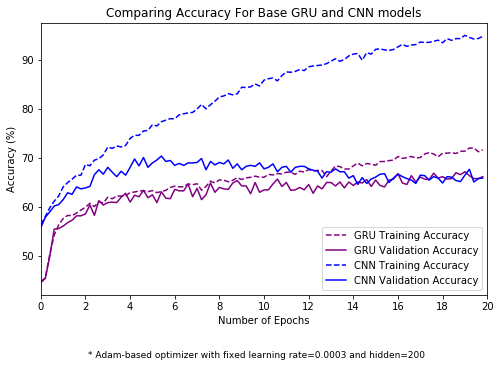

In [19]:
# Run this so your plots show properly
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 5]

def get_plot_values(accuracies):
    training_acc = [acc[2] for acc in accuracies]
    val_acc = [acc[3] for acc in accuracies]
    training_acc_fmt = []
    for i, acc in enumerate(training_acc):
        if i % 6 == 0:
            continue
        elif i % 7 == 0:
            continue
        else:
            training_acc_fmt.append(acc)
    val_acc_fmt = []
    for i, acc in enumerate(val_acc):
        if i % 6 == 0:
            continue
        elif i % 7 == 0:
            continue
        else:
            val_acc_fmt.append(acc)
    return training_acc_fmt, val_acc_fmt

accuracies_gru_loaded = pkl.load(open("gru_accuracies", "rb"))
gru_training, gru_val = get_plot_values(accuracies_gru_loaded)
accuracies_cnn_loaded = pkl.load(open("cnn_accuracies2", "rb"))
cnn_training, cnn_val = get_plot_values(accuracies_cnn_loaded)


plt.plot(list(np.arange(0, 20, 0.2)), gru_training, label="GRU Training Accuracy", color='purple', linestyle='--') 
plt.plot(list(np.arange(0, 20, 0.2)), gru_val, label="GRU Validation Accuracy", color='purple') 
plt.plot(list(np.arange(0, 20, 0.2)), cnn_training, label="CNN Training Accuracy", color='blue', linestyle='--') 
plt.plot(list(np.arange(0, 20, 0.2)), cnn_val, label="CNN Validation Accuracy", color='blue') 


plt.title('Comparing Accuracy For Base GRU and CNN models')
plt.legend(loc = 'lower right')
# plt.ylim([0, 15])
plt.xlim([0, 20])
plt.xticks(list(range(0,21,2)))
plt.ylabel('Accuracy (%)')
plt.xlabel('Number of Epochs')
txt="* Adam-based optimizer with fixed learning rate=0.0003 and hidden=200"
plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=9)
plt.show()

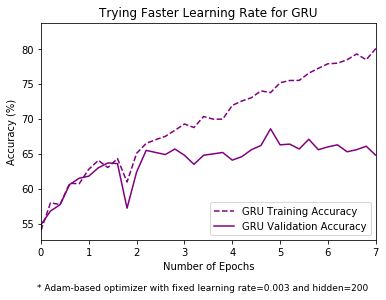

In [24]:
accuracies_gru_loaded = pkl.load(open("gru_accuracies_0.003_2", "rb"))
gru_training, gru_val = get_plot_values(accuracies_gru_loaded)


plt.plot(list(np.arange(0, 10, 0.2)), gru_training, label="GRU Training Accuracy", color='purple', linestyle='--') 
plt.plot(list(np.arange(0, 10, 0.2)), gru_val, label="GRU Validation Accuracy", color='purple') 
# plt.plot(list(np.arange(0, 20, 0.2)), cnn_training, label="CNN Training Accuracy", color='blue', linestyle='--') 
# plt.plot(list(np.arange(0, 20, 0.2)), cnn_val, label="CNN Validation Accuracy", color='blue') 


plt.title('Trying Faster Learning Rate for GRU')
plt.legend(loc = 'lower right')
# plt.ylim([0, 15])
plt.xlim([0, 7])
plt.xticks(list(range(0,8,1)))
plt.ylabel('Accuracy (%)')
plt.xlabel('Number of Epochs')
txt="* Adam-based optimizer with fixed learning rate=0.003 and hidden=200"
plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=9)
plt.show()

In [ ]:
def 

mdb = ModelDatasetBuilder('hw2_data', vocab_size=50000)
mdb.load_fasttext_vectors_into_vocabulary('wiki-news-300d-1M.vec')
embeddings = mdb.get_embedding_vector()
print(embeddings)
training_vectors, val_vectors = mdb.get_indexed_text_vectors()
print(training_vectors)